# Part 1 : Data Analysis and Feature Engineering

In [82]:
import pandas as pd
import numpy as np

In [58]:
nifty = pd.read_csv('dataset/data_with_features/nifty.csv')

In [59]:
nifty.head()

,Date,Date.1,Open,High,Low,Close,Volume,Turnover,Year,Month,...,vol_(t+1),volume_shock,VOL_SHOCK_DIR,price_t+1,price_shock,price_black_swan,PRICE_SHOCK_DIR,BLACK_SWAN_SHOCK_DIR,not_vol_shock,price_shock_w/0_vol_shock
0,2015-01-01,2015-01-01,11214.80,11235.75,11166.35,11215.70,4246150,3.575100e+09,2015,1,...,10004862.0,1,1.0,11372.10,0,0,NaN,NaN,0,0
1,2015-01-02,2015-01-02,11214.65,11399.10,11214.65,11372.10,10004862,9.645600e+09,2015,1,...,10004862.0,0,NaN,11372.10,0,0,NaN,NaN,1,0
2,2015-01-03,2015-01-02,11214.65,11399.10,11214.65,11372.10,10004862,9.645600e+09,2015,1,...,10004862.0,0,NaN,11372.10,0,0,NaN,NaN,1,0
3,2015-01-04,2015-01-02,11214.65,11399.10,11214.65,11372.10,10004862,9.645600e+09,2015,1,...,8858018.0,1,0.0,11248.55,0,0,NaN,NaN,0,0
4,2015-01-05,2015-01-05,11369.35,11433.75,11186.95,11248.55,8858018,1.059000e+10,2015,1,...,12515739.0,1,1.0,10959.90,1,1,0.0,0.0,0,0


In [60]:
nifty = nifty.drop("Date.1", axis=1)

In [65]:
def scale_down(a,scale_up=100):
    return scale_up*(a - min(a)) / (max(a) - min(a))

In [62]:
nifty['Volume'] = scale_down(nifty['Volume'])

In [66]:
nifty['Turnover'] = scale_down(nifty['Turnover'])

In [70]:
nifty['vol_(t+1)'] = scale_down(nifty['vol_(t+1)'])

In [78]:
nifty = nifty[:-1]

In [80]:
nifty.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover', 'Year',
       'Month', 'Day', 'WeekOfYear', 'vol_(t+1)', 'volume_shock',
       'VOL_SHOCK_DIR', 'price_t+1', 'price_shock', 'price_black_swan',
       'PRICE_SHOCK_DIR', 'BLACK_SWAN_SHOCK_DIR', 'not_vol_shock',
       'price_shock_w/0_vol_shock'],
      dtype='object')

In [96]:
columns = list(nifty.columns)

In [104]:
for i in range(1,len(columns)):
    print('NaN count for {}: '.format(columns[i]), list(np.isnan(nifty[columns[i]])).count(True))

NaN count for Open:  0
NaN count for High:  0
NaN count for Low:  0
NaN count for Close:  0
NaN count for Volume:  0
NaN count for Turnover:  0
NaN count for Year:  0
NaN count for Month:  0
NaN count for Day:  0
NaN count for WeekOfYear:  0
NaN count for vol_(t+1):  0
NaN count for volume_shock:  0
NaN count for VOL_SHOCK_DIR:  177
NaN count for price_t+1:  0
NaN count for price_shock:  0
NaN count for price_black_swan:  0
NaN count for PRICE_SHOCK_DIR:  349
NaN count for BLACK_SWAN_SHOCK_DIR:  349
NaN count for not_vol_shock:  0
NaN count for price_shock_w/0_vol_shock:  0


In [ ]:
# Checking for correlation between the selected features

In [111]:
features= ['Open','High','Close','Volume','Turnover','Day','Month','WeekOfYear','volume_shock','price_shock','not_vol_shock']

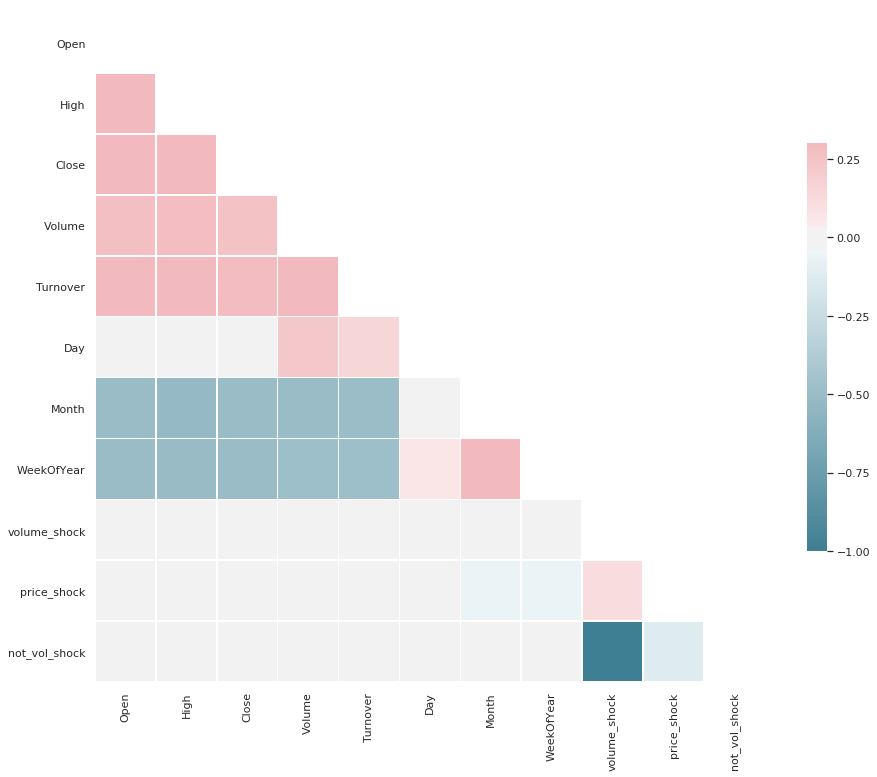

In [115]:

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
# Compute the correlation matrix
corr = nifty[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### As expected, volume_shock and not_vol_shock must have a correlation of 1, made a mistake of including both !


We can also see that (Open, high, close, volume and turnover) have a high correlation with week and month, and the color code is more or less the same, so perhaps we can make use of feature engineering to compress weekofyear and month into one

### adding week and month seems like a simple but workable idea, so I'll do that.

In [116]:
nifty['weekAndMonth'] = nifty['WeekOfYear'].values + nifty['Month'].values

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [128]:
# Also, including day seems like a bad idea, since this dataset is augmented

In [129]:
features= ['Open','High','Close','Volume','Turnover','weekAndMonth','volume_shock','price_shock']

# Part 2 : Regression Modelling

>Now that I have finalized on the features to be used and all other preprocessing, I'll now fit all of that into a single function so I can fit my testing data into that before predictions.

In [169]:
def preprocess_train(data,data_type='not train'):
    data['Volume'] = scale_down(data['Volume'])
    data['Turnover'] = scale_down(data['Turnover'],10)
    data['vol_(t+1)'] = scale_down(data['vol_(t+1)'])
    if(data_type=='train'):
        data = data[:-1].copy()
    data['weekAndMonth'] = data['WeekOfYear'].values + data['Month'].values
    return data[features],data['price_t+1'].values

In [ ]:
nifty = pd.read_csv('dataset/data_with_features/nifty.csv')
infy = pd.read_csv('dataset/data_with_features/infy.csv')

In [159]:
X_train,y_train = preprocess_train(nifty.copy(),'train')

In [170]:
X_test_tcs,y_test_tcs = preprocess_train(tcs.copy())

In [174]:
X_test_infy,y_test_infy = preprocess_train(infy.copy())

#### I'll use l2 regression and emsemble methods for my predictions